# 4.  EDA w/ VADER Sentiment Analysis

---

The purpose of this notebook is mainly to **append the sentiment VADER scores to all tweets**.  The main function that does this is `append_sentiment()`.  Then once that is done, we will look at some preliminary graphs that could point us in the right path in terms of looking at more important trends.

## Import libraries and read in file

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [71]:
# df = pd.read_csv('./Data/combined_us.csv', index_col=0).reset_index(drop=True)
df = pd.read_csv('./Data/all_sentiment.csv', parse_dates=['created_at'], infer_datetime_format=True)
pd.set_option('display.max_columns', 50)

In [72]:
df.dtypes

created_at            datetime64[ns, UTC]
favorite_count                      int64
status_id                           int64
lang                               object
place_full_name                    object
retweet_count                       int64
text                               object
account_created_at                 object
screen_name                        object
followers_count                     int64
friends_count                       int64
verified                             bool
city                               object
state                              object
is_reply                             bool
is_retweet                           bool
country_code                       object
place_type                         object
neg                               float64
neu                               float64
pos                               float64
compound                          float64
dtype: object

**Take out all line breaks in your text.  This is a must or else sentiment analysis tool or pandas will act on the line breaks and mess up data frame!**

In [43]:
df['text'] = df['text'].replace(to_replace=["\\t|\\n|\\r", "\t|\n|\r"], value=[' ', ' '], regex=True)

## Tack on state policy dates

In the next section, we will tack on state policy dates to the main data set.

In [81]:
sip = pd.read_csv('./data/state_policies_new.csv', parse_dates=['date_stay_home', 'date_end_stay_home'], infer_datetime_format=True)
sip.head()

,state_short,state_full,date_shelter_announced,date_shelter_effective,date_stay_home,date_travel_quarentine,date_nonessential_close,date_large_gather_ban,date_school_close,date_rest_limit,primary_delay,date_emergency_dec,date_end_stay_home,date_end_travel_quarentine,date_open_nonessential,date_end_large_gather_ban,date_end_school_close,date_end_rest_limit,date_mask_required,mask_required,shelter_issued,stay_home_order,travel_quarentine_issued,nonessential_close_order,large_gather_ban_issued,school_closures,rest_limit_issued,emergency_declaration,end_stay_home,end_travel_quarentine,open_nonessential,end_large_gather_ban,schools_open_in_person,end_rest_limit
0,NY,New York,2020-03-20,2020-03-22,2020-03-22,2020-06-25 00:00:00,2020-03-22,2020-03-22,2020-03-20,2020-03-16,Canceled,2020-03-07,2020-06-27,NaN,2020-05-14,2020-05-22,NaN,2020-06-22,2020-04-15,Entire State,1,1,1,1,1,1,1,1,1,0,1,1,0,1
1,MA,Massachusetts,2020-03-23,2020-03-24,NaT,2020-03-27 00:00:00,2020-03-24,2020-03-17,2020-03-16,2020-03-17,NaN,2020-03-10,NaT,NaN,2020-05-19,NaN,NaN,2020-06-08,2020-05-06,Entire State,1,0,1,1,1,1,1,1,0,0,1,0,0,1
2,RI,Rhode Island,2020-03-28,2020-03-28,2020-03-28,2020-03-28 00:00:00,2020-03-30,2020-03-28,2020-03-23,2020-03-17,Postponed,2020-03-09,2020-05-09,NaN,2020-05-09,2020-06-01,NaN,2020-05-30,2020-04-20,Entire State,1,1,1,1,1,1,1,1,1,0,1,1,0,1
3,NH,New Hampshire,2020-03-26,2020-03-27,2020-03-27,NaN,2020-03-27,2020-03-16,2020-03-16,2020-03-16,NaN,2020-03-13,2020-06-15,NaN,2020-05-11,NaN,NaN,2020-05-18,NaN,Parts of State,1,1,0,1,1,1,1,1,1,0,1,0,0,1
4,ME,Maine,2020-03-31,2020-04-02,2020-04-01,2020-04-03 00:00:00,2020-03-25,2020-03-18,2020-04-02,2020-03-18,Postponed,2020-03-15,NaT,NaN,2020-05-01,2020-06-01,NaN,2020-06-01,2020-05-01,Entire State,1,1,1,1,1,1,1,1,0,0,1,1,0,1


Merge on state code but keep the data frame texts even if you can't find a policy date for it.

In [87]:
df = pd.merge(df, sip[['state_short', 'date_stay_home', 'date_end_stay_home']], left_on = 'state', right_on = 'state_short', how = 'left')

In [88]:
df = df.drop(columns = ['state_short'])

In [89]:
df.head()

,created_at,favorite_count,status_id,lang,place_full_name,retweet_count,text,account_created_at,screen_name,followers_count,friends_count,verified,city,state,is_reply,is_retweet,country_code,place_type,neg,neu,pos,compound,date_stay_home,date_end_stay_home
0,2020-08-10 04:44:47+00:00,0,1292683286603542529,en,"Dallas, TX",0,Matching our swimsuits may have been a step to...,2009-06-25 19:58:31+00:00,LoraleeL,1415,610,False,Dallas,TX,False,False,US,unspecified,0.000,0.871,0.129,0.7783,2020-04-02,2020-04-30
1,2020-08-10 05:46:03+00:00,0,1292698706261680128,en,"Houston, TX",0,#MaybeInYourCity All Month Long @_blessed_hand...,2009-11-20 22:25:08+00:00,_blessed_hands_,987,1091,False,Houston,TX,False,False,US,unspecified,0.048,0.825,0.128,0.4939,2020-04-02,2020-04-30
2,2020-08-10 05:35:28+00:00,0,1292696044250128387,en,"Houston, TX",0,#MaybeInYourCity All Month Long @_blessed_hand...,2009-11-20 22:25:08+00:00,_blessed_hands_,987,1091,False,Houston,TX,False,False,US,unspecified,0.048,0.825,0.128,0.4939,2020-04-02,2020-04-30
3,2020-08-10 05:40:03+00:00,0,1292697195058266112,en,"San Antonio, TX",0,#MaybeInYourCity All Month Long @_blessed_hand...,2009-11-20 22:25:08+00:00,_blessed_hands_,987,1091,False,San Antonio,TX,False,False,US,unspecified,0.048,0.825,0.128,0.4939,2020-04-02,2020-04-30
4,2020-08-10 05:47:43+00:00,0,1292699124794568715,en,"San Antonio, TX",0,#MaybeInYourCity All Month Long @_blessed_hand...,2009-11-20 22:25:08+00:00,_blessed_hands_,987,1091,False,San Antonio,TX,False,False,US,unspecified,0.048,0.825,0.128,0.4939,2020-04-02,2020-04-30


## Grouping by state

Initially, I broke up the tweets by state to test out the `append_sentiment()` function.  Below is the function that takes the Twitter dataset and separates it by state and returns the subsequent data set.

In [114]:
def group_by_state(dataset, state=None, city=None):
    
    # reads in any state that is in the dataset and groups by that state and sets it to a variable 'df'
    if state:
        df = dataset.loc[dataset['state'] == state,].copy().reset_index(drop=True)
    # below is only for nyc
    elif city=='nyc':
        df = dataset.loc[(dataset['city']=='Manhattan') |
       (dataset['city']=='Bronx') |
       (dataset['city']=='Brooklyn') |
       (dataset['city']=='Staten Island') |
       (dataset['city']=='Queens'),].copy().reset_index(drop=True)
    
    return df

In [115]:
states = ['GA', 'CO', 'CA', 'IL', 'NY', 'WA']

# setting each dataframe to its state code
ga = group_by_state(df, state='GA', city=None)
co = group_by_state(df, state='CO', city=None)
ca = group_by_state(df, state='CA', city=None)
il = group_by_state(df, state='IL', city=None)
wa = group_by_state(df, state='WA', city=None)

Below, I am manipulating New York City's data:

In [116]:
nyc = df.loc[(df['city']=='Manhattan') |
       (df['city']=='Bronx') |
       (df['city']=='Brooklyn') |
       (df['city']=='Staten Island') |
       (df['city']=='Queens'),].copy().reset_index(drop=True)

## VADER Sentiment

[VADER](https://github.com/cjhutto/vaderSentiment) (Valence Aware Dictionary and sEntiment Reasoner) Sentiment is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.  It uses a combination of sentiment lexicons and an overall compound score.

> The compound score is computed by summing the valence scores of each word in the [lexicon](https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vader_lexicon.txt), adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

> The 'pos', 'neu', and 'neg' scores are ratios for proportions of text that fall in each category (so these should all add up to be 1... or close to it with float operation). These are the most useful metrics if you want multidimensional measures of sentiment for a given sentence.

Citation:

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [25]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [26]:
analyzer = SentimentIntensityAnalyzer()

In [63]:
def append_sentiment(state):
    """takes a state dataset and adds VADER sentiment scores to the dataframe"""
    # import VADER sentiment library
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    # instantiating the class
    analyzer = SentimentIntensityAnalyzer()
    
    # create a dataframe for the VADER sentiments to be appended to
    sentiment = pd.DataFrame(columns = ['status_id', 'neg', 'neu', 'pos', 'compound'])
    
    # for cross check
    count = 0
    
    # loop over every row in dataset and use VADER analyzer to output a dict,
    # turn that dict into a pandas dataframe,
    # append it to the sentiment dataframe we created above
    for index in range(state.shape[0]):
        vs = analyzer.polarity_scores(state.iloc[index, 6])
        df = pd.DataFrame([[state.iloc[index,2], vs['neg'], vs['neu'], vs['pos'], vs['compound']]], 
                          columns = ['status_id', 'neg', 'neu', 'pos', 'compound'])
        sentiment = sentiment.append(df)
        
        # progress checks
        count += 1
        if count == 40_000:
            print(sentiment)
        else:
            if count % 50_000 == 0:
                print(f'Progress checks: {count} out of 250_000')
    
    # merging on status_id
    df_sentiment = pd.merge(state, sentiment, on='status_id')
    
    return df_sentiment.reset_index(drop=True)

**The below code will analyze sentiment for the entire dataframe.  Be careful when running this code as it will take a long time!**

(150,000 rows takes around 7 min)

In [57]:
%%time
sentiment = append_sentiment(df)

              status_id    neg    neu    pos  compound
0   1292683286603542529  0.000  0.871  0.129    0.7783
0   1292706983846580224  0.000  1.000  0.000    0.0000
0   1292687112509120513  0.000  0.881  0.119    0.3182
0   1292686321895473152  0.146  0.659  0.195    0.5332
0   1292682413362094080  0.000  1.000  0.000    0.0000
..                  ...    ...    ...    ...       ...
0   1278117949501509635  0.056  0.699  0.245    0.8908
0   1278114020994793472  0.000  0.812  0.188    0.8213
0   1278126786526752768  0.127  0.592  0.281    0.7906
0   1278121586361581572  0.000  0.676  0.324    0.9686
0   1278110960398544896  0.000  0.831  0.169    0.8176

[40000 rows x 5 columns]
Progress checks: 50000 out of 234_792
Progress checks: 100000 out of 234_792
Progress checks: 150000 out of 234_792
Progress checks: 200000 out of 234_792
CPU times: user 15min 8s, sys: 1min 10s, total: 16min 19s
Wall time: 16min 31s


In [60]:
# sentiment.to_csv('./data/all_sentiment.csv', index=False)

## VADER scores for each individual tweet

Below is a function that graphs showing compound sentiment scores **for each individual tweet**

In [119]:
def sentiment_graphs(sentiment_df):
    
    # list of sentiments to iterate through in the for loop
    sentiments = ['compound', 'pos', 'neu', 'neg']
    # this dictionary is for the title of the graph
    sentiment_dict = {'compound': 'compound',
                      'pos': 'positive',
                      'neu': 'neutral',
                      'neg': 'negative'}
    
    # making the graphs
    for sentiment in sentiments:
        plt.bar(x=sentiment_df.index, height=sentiment_df[sentiment], color='deepskyblue')
        plt.title(f'{sentiment_dict[sentiment]} Scores for All Tweets in NYC')
        plt.xlabel('Tweet Number')
        plt.ylabel('Score')
        plt.show();


## Sentiments for all target states

I will be using the function I made above (called `append_sentiments()`) to create sentiments for all other target states below.

---

Target states include:  `['Georgia', 'Colorado', 'California', 'Illinois', 'Washington State', 'New York City']`

State Codes: `['ga', 'co', 'ca', 'il', 'wa']`

In [122]:
ga_sentiment = append_sentiment(ga)

In [123]:
co_sentiment = append_sentiment(co)

In [124]:
ca_sentiment = append_sentiment(ca)

In [125]:
il_sentiment = append_sentiment(il)

In [126]:
wa_sentiment = append_sentiment(wa)

In [127]:
nyc_sentiment = append_sentiment(nyc)

### Average Compound, Positive, and Negative Scores by Target State, etc.

Below is a loop that grabs the mean of the positive, negative, and compound scores by state and appends them to the empty respective lists.  This uses the state sentiments that we ran above.

In [18]:
sentiments_by_state = [ga_sentiment,
                       co_sentiment,
                       ca_sentiment,
                       il_sentiment,
                       wa_sentiment,
                       nyc_sentiment]

pos_sentiment = []
neg_sentiment = []
comp_sentiment = []
for sentiment in sentiments_by_state:
    pos_sentiment.append(sentiment['pos'].mean())
    neg_sentiment.append(sentiment['neg'].mean())
    comp_sentiment.append(sentiment['compound'].mean())

A graph comparing compound, positive, and negative sentiment scores.

Text(0.5, 1.0, 'Average Compound Score by Target State and New York City')

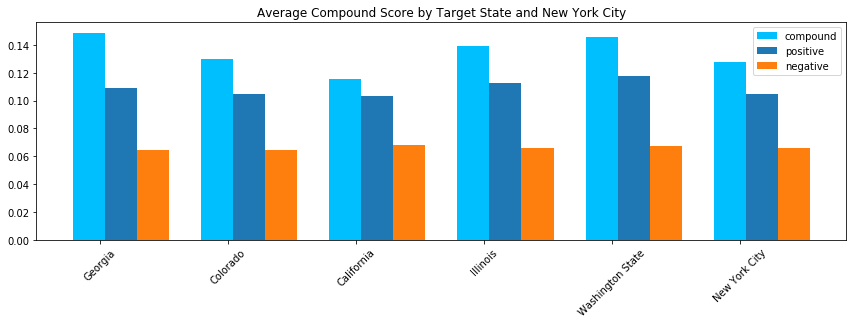

In [36]:
labels = ['Georgia', 'Colorado', 'California', 'Illinois', 'Washington State', 'New York City']
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
fig.subplots_adjust(right = 2)
ax.bar(x - (width/3), height = comp_sentiment, width = width, label='compound', color='deepskyblue')
ax.bar(x + (2 * width)/3, height = pos_sentiment, width = width, label = 'positive')
ax.bar(x + (5 * width)/3, height = neg_sentiment, width = width, label = 'negative')

ax.legend(loc = 'upper right')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
plt.title('Average Compound Score by Target State and New York City')
